<a href="https://colab.research.google.com/github/Sumyom354/Solar_cells/blob/main/solar_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#to unzip the dataset
!unzip "/content/drive/MyDrive/elpv-dataset-master.zip"

Archive:  /content/drive/MyDrive/elpv-dataset-master.zip
289a37eff6c443e8fce0edd6cda5ba4cbf5fe19f
   creating: elpv-dataset-master/
  inflating: elpv-dataset-master/LICENSE.md  
  inflating: elpv-dataset-master/README.md  
   creating: elpv-dataset-master/doc/
   creating: elpv-dataset-master/doc/images/
  inflating: elpv-dataset-master/doc/images/overview.jpg  
   creating: elpv-dataset-master/images/
 extracting: elpv-dataset-master/images/cell0001.png  
 extracting: elpv-dataset-master/images/cell0002.png  
 extracting: elpv-dataset-master/images/cell0003.png  
 extracting: elpv-dataset-master/images/cell0004.png  
  inflating: elpv-dataset-master/images/cell0005.png  
 extracting: elpv-dataset-master/images/cell0006.png  
 extracting: elpv-dataset-master/images/cell0007.png  
 extracting: elpv-dataset-master/images/cell0008.png  
 extracting: elpv-dataset-master/images/cell0009.png  
 extracting: elpv-dataset-master/images/cell0010.png  
 extracting: elpv-dataset-master/images/cell

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint


### **Import Data**

In [ ]:
import os
#Load and preprocess the dataset
folder_path = '/content/elpv-dataset-master'

# Get a list of all file names in the folder
file_names = os.listdir(folder_path)

# Get the number of files in the folder
num_files = len(file_names)

print("Number of files in the folder:", num_files)
# Print the list of file names
print("File names:")
for file_name in file_names:
    print(file_name)

Number of files in the folder: 6
File names:
images
utils
labels.csv
README.md
LICENSE.md
doc


In [ ]:
import os

folder_path = '/content/elpv-dataset-master/images'  # Replace with the actual path to the folder

# Get a list of all file names in the folder
file_names = os.listdir(folder_path)
# Filter the list to include only PNG files
png_files = [file for file in file_names if file.endswith('.png')]

# Get the count of PNG files
num_images = len(png_files)

print("Number of PNG images in the folder:", num_images)


Number of PNG images in the folder: 2624


In [ ]:
# Load dataset function
def load_dataset(csv_file='/content/elpv-dataset-master/labels.csv'):
    # Load CSV file containing image paths and labels
    data = np.genfromtxt(csv_file, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    # Print size of labels for debugging
    print(f"Number of image paths: {len(image_fnames)}")
    print(f"Number of probabilities: {len(probs)}")
    print(f"Number of types: {len(types)}")

    # Load images as numpy arrays
    def load_image(file_path):
        with Image.open(file_path) as img:
            return np.asarray(img)

    images = []
    dir_path = os.path.dirname(csv_file)
    for fname in image_fnames:
        img_path = os.path.join(dir_path, fname)
        if os.path.exists(img_path):
            images.append(load_image(img_path))
        else:
            print(f"Warning: Image file {img_path} not found.")

    images = np.array(images)
    print(f"Loaded images: {len(images)}")
    return images, probs, types

In [ ]:
# Preprocess labels (convert probabilities to binary labels)
def preprocess_labels(probs):
    return np.where(probs > 0.5, 0, 1)  # Defect (0) and Non-defect (1)

In [ ]:
# Preprocessing: Convert grayscale to RGB, resize, and normalize
def preprocess_images(images, target_size=(227, 227)):
    processed_images = []
    for img in images:
        if len(img.shape)==2:
           img_rgb=np.stack([img]*3,axis=-1)
        else:
           img_rgb=img
        img_pil = Image.fromarray(np.uint8(img_rgb.squeeze() * 255))
        img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)  # Use LANCZOS for high-quality resampling
        processed_images.append(img_to_array(img_resized))
    return np.array(processed_images)



In [ ]:
# Load and preprocess the dataset
images, probs, types = load_dataset()
#Verify lengths match
print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(probs)}")


Number of image paths: 2624
Number of probabilities: 2624
Number of types: 2624
Loaded images: 2624
Number of images: 2624
Number of labels: 2624


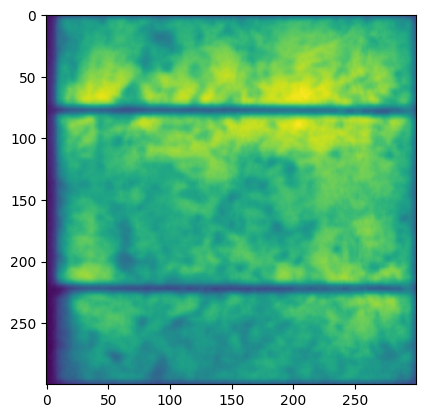

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[80])

In [ ]:
#Preprocess images (resize and convert to RGB)
if len(images) == len(probs):
    X = preprocess_images(images)
    y = preprocess_labels(probs)
else:
    raise ValueError("Mismatch between number of images and labels.")

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [ ]:
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (2099, 227, 227, 3), (2099,)
Validation set: (262, 227, 227, 3), (262,)
Test set: (263, 227, 227, 3), (263,)


In [ ]:
#Normalize images by dividing by 255 to scale pixel values between 0 and 1
X_train=X_train.astype('float32')/255
X_valid=X_valid.astype('float32')/255
X_test=X_test.astype('float32')/255

In [ ]:
# Ensure labels are one-hot encoded for categorical_crossentropy
y_train = to_categorical(y_train, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [ ]:
# Define the custom AlexNet model
def create_alexnet(input_shape=(227, 227, 3)):
    model = Sequential()

    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))

    # Output layer for binary classification
    model.add(Dense(2, activation='softmax'))

    return model

In [ ]:
# Create and compile the model
model = create_alexnet(input_shape=(227, 227, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           8,1

 Total params: 58,295,042 (222.38 MB)

 Trainable params: 58,292,290 (222.37 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Train the model with a checkpoint
checkpoint = ModelCheckpoint(
    '/content/solar_module_model_best.keras',  # Change .h5 to .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint]
)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6091 - loss: 28.8252
Epoch 1: val_accuracy improved from -inf to 0.27863, saving model to /content/solar_module_model_best.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 891ms/step - accuracy: 0.6102 - loss: 28.3632 - val_accuracy: 0.2786 - val_loss: 491.7088
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6827 - loss: 2.8026
Epoch 2: val_accuracy improved from 0.27863 to 0.46565, saving model to /content/solar_module_model_best.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - accuracy: 0.6827 - loss: 2.7829 - val_accuracy: 0.4656 - val_loss: 9.5372
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6960 - loss: 1.7710
Epoch 3: val_accuracy improved from 0.46565 to 0.75954, saving model to /content/solar_module_model_best.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.6957 - loss: 1.7658 - val_accuracy: 0.7595 - val_loss: 0.5827
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.8333 - loss: 0.4781
Test Accuracy: 0.84


In [ ]:
# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=['Defect', 'Non-Defect']))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
              precision    recall  f1-score   support

      Defect       0.83      0.66      0.73        87
  Non-Defect       0.85      0.93      0.89       176

    accuracy                           0.84       263
   macro avg       0.84      0.79      0.81       263
weighted avg       0.84      0.84      0.83       263



## **Visualization**

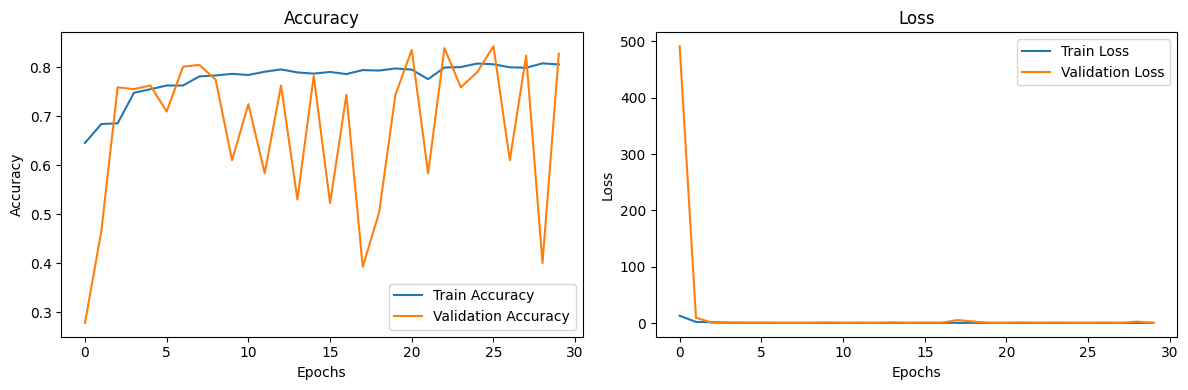

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Output**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


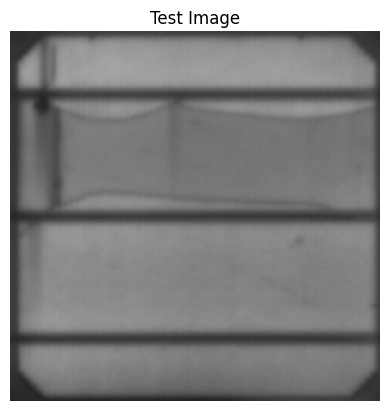

Predicted Class: mono
Defect Probability: 0.53


In [ ]:
from PIL import Image
import numpy as np
from keras.models import load_model, Model
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/solar_module_model_best.keras')

# Function to read and preprocess a single image
def read_and_preprocess_image(image_path, target_size=(227, 227)):  # Resize to 227x227
    image = Image.open(image_path)
    image_rgb = image.convert('RGB')
    image_resized = image_rgb.resize(target_size, Image.Resampling.LANCZOS)
    image_array = img_to_array(image_resized)
    image_array = np.expand_dims(image_array, axis=0)
    image_array /= 255.0  # Normalize pixel values
    return image_array

# Example image path (replace with the path to your test image)
test_image_path = '/content/elpv-dataset-master/images/cell0026.png'

# Read and preprocess the test image
test_image = read_and_preprocess_image(test_image_path)

# Make predictions on the test image
pred_probabilities = model.predict(test_image)

# Get the predicted class index
predicted_class_index = np.argmax(pred_probabilities)

# Get the probability for the predicted class
predicted_prob = pred_probabilities[0][predicted_class_index]

# Map the predicted label to the corresponding class name
class_names = ['mono', 'poly']  # Update class names as per your dataset
predicted_class = class_names[predicted_class_index]

# Visualize the test image
plt.imshow(np.squeeze(test_image))
plt.title("Test Image")
plt.axis('off')
plt.show()

# Display the output
print(f"\033[1mPredicted Class:\033[0m {predicted_class}")
print(f"\033[1mDefect Probability:\033[0m {predicted_prob:.2f}")
